# Section 5. Satellite imagery

#### Instructor: Pierre Biscaye

A common problem for conducting research in developing countries are data availability constraints for many characteristics of economic interest. One way to overcome this data scarcity is to complement traditional data sources with remote sensing data. Remote sensing data have been used to measure or predict a wide variety of outcomes such as land use, population density, poverty, agricultural production, weather, etc. 

An increasingly-used source is satellite imagery. Two recent papers summarize applications of satellite data in economics in particular:
- [Donaldson, Dave, and Adam Storeygard. "The view from above: Applications of satellite data in economics." Journal of Economic Perspectives 30.4 (2016): 171-198.](https://pubs.aeaweb.org/doi/pdf/10.1257/jep.30.4.171)
- [Jain, Meha. "The benefits and pitfalls of using satellite data for causal inference." Review of Environmental Economics and Policy (2020).](https://www.journals.uchicago.edu/doi/abs/10.1093/reep/rez023?journalCode=reep)

There are many others but these may be a useful starting point to complement the material presented in this course.
    
### Learning Objectives 
    
* Accessing satellite imagery through Google Earth Engine
* Understand what satellite imagery looks like in raw form
* Deriving indicators using satellite imagery

### Sections

1. Accessing satellite imagery
2. Visualizing satellite imagery
3. Deriving indicators

In [1]:
# Import Packages
import random
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import sys
import rasterio
from matplotlib.colors import LinearSegmentedColormap

# 1. Accessing satellite imagery

## Google's Earth Engine

An important tool for working with remotely sensed and satellite data is Google's **Earth Engine**. We reviewed this tool last session.

Earth Engine is home to hundreds of public remote sensing/geospatial datasets totaling more than thirty petabytes, and is continuously updated as images are captured. Check out the [Data Catalog](https://developers.google.com/earth-engine/datasets) for more information.

Let's connect to GEE first, then start loading in some data.

In [2]:
import ee

In [3]:
ee.Initialize(project="ee-pbiscaye")

In [4]:
# Check access
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


## Major satellite data catalogs

Today, we'll work with two very commonly used satellite data sources:
* Sentinel-2 (ESA): high-resolution (10m) and frequent revisits (5 days for 2A and 2B combined in some parts of the world, 10 days elsewhere), launched recently, useful for precise measures
* MODIS (NASA): lower resolution (250m-1km) but daily global coverage, useful for high-frequency coarser analysis

There is usually a tradeoff between spatial resolution and spectral resolution. Sentinel-2 captures 12 spectral bands at 10m resolution. MODIS captures 36 bands at a 1km resolution (7 at 500m and 2 at 250m). You can think of Sentinel-2 as a kind of high-resolution camera (though there are even more high-resolution private satellite imagery sources), and MODIS as a kind of scientific laboratory with a wider array of sensors. 

Sentinel-2 is designed for land monitoring, but MODIS' additional sensors can capture a broad array of other types of information. MODIS thermal sensors detect land surface temperature, cloud top temperature, and more. MODIS can also detect water vapor absorption and computes measures of atmospheric "haze". Finally, MODIS has ocean-specific bands to detect things like plankton fluorescence. These sources can be useful complements to each other.

Note that GEE hosts many collections related to each of these satellites. For Sentinel-2, we'll use the Surface Reflectance collection which is already processed to remove atmospheric haze. For MODIS, we'll use the Terra Surface Reflectance Daily Global product. This is a daily dataset but unlike many other MODIS catalogs does not have pre-cleaning to deal with cloud cover. We will have to do that ourselves.  

There are also many other satellite data souces in the GEE catalog. For example, Landsat 8/9 (USGS) is a high-resolution (30m multispectral, 15m panchromatic) with a 16-day revisit period. It has few bands (9 at 30m) but a long historical record (40+ years), so is useful for looking at changes over time.

## Filtering

The catalogs of data associated with each of these satellites can be huge! We will want to **filter over space and time**.

A single Sentinel-2 tile is $100 \text{ km} \times 100 \text{ km}$. MODIS tiles are much larger, around $1200 \text{ km} \times 1200 \text{ km}$. We'll be looking at the commune of Sizun in Bretagne, France, which in January 2026 broke all-time records for total rainfall. This is a good location for exploring how cloud cover may affect satellite imagery, and testing whether common free data sources are able to identify variations in surface water in such a context.

We will focus on a small area around the commune, to reduce the computational load for our analyses. Specifically, we will draw a $10 \text{ km} \times 10 \text{ km}$ box around Sizun. Based on the resolution of the datasets, this will include 1 million 10m resolution pixels in the Sentinel-2 data but just 400 500m resolution pixels in the MODIS data. This means processing will likely still run faster with daily MODIS data than every 10 day Sentinel-2 data.

For time, we will include data for the past 6 months. The number of tiles that will be retrieved will vary across satellites, but for Sentinel-2 this would be around 36 images for the 180 day period.

Now let's filter and "load" the data. Note that we are not actively loading all the data - just linking to GEE to explore and interact with the data. 

In [12]:
import geemap
# Initialize map for later visualizing
Map = geemap.Map()

# 1. Define the point and create a 10km x 10km square (5km radius buffer)
sizun_point = ee.Geometry.Point([-4.0507, 48.3916])
study_area = sizun_point.buffer(5000).bounds() # 5000m radius = 10km square
start_date = '2025-09-01'
end_date = '2026-02-01'

# 2. Load and Clip Sentinel-2 S2_SR_HARMONIZED (10m Resolution)
s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(study_area)
                 .filterDate(start_date, end_date)
                 .map(lambda img: img.clip(study_area))) # Crop to the 10km box

# 3. Load and Clip MODIS MOD09GA (500m Resolution)
modis_daily = (ee.ImageCollection("MODIS/061/MOD09GA")
               .filterBounds(study_area)
               .filterDate(start_date, end_date)
               .map(lambda img: img.clip(study_area)))

## Inspecting

Having loaded the image collection, it is useful to explore its characteristics. We can of course read about it in the GEE catalog, but you can also access metadata here.

We can use the `.first()` method to take a single image from the collection and inspect it. Key aspects to look at include:
* available **bands** `bandNames()`
* metadata **properties** `propertyNames()`

In [6]:
# Get the first image in the collection
sample_img = s2_collection.first()

# 1. See all available Bands
print("Bands:", sample_img.bandNames().getInfo())

# 2. See all metadata properties (like cloud cover, sensor angle, etc.)
print("Metadata Keys:", sample_img.propertyNames().getInfo())

Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']
Metadata Keys: ['system:footprint', 'system:version', 'system:id', 'SPACECRAFT_NAME', 'SATURATED_DEFECTIVE_PIXEL_PERCENTAGE', 'BOA_ADD_OFFSET_B12', 'CLOUD_SHADOW_PERCENTAGE', 'SENSOR_QUALITY', 'GENERATION_TIME', 'CLOUDY_PIXEL_OVER_LAND_PERCENTAGE', 'CLOUD_COVERAGE_ASSESSMENT', 'THIN_CIRRUS_PERCENTAGE', 'GRANULE_MEAN_WV', 'BOA_ADD_OFFSET_B1', 'BOA_ADD_OFFSET_B2', 'DATASTRIP_ID', 'BOA_ADD_OFFSET_B5', 'BOA_ADD_OFFSET_B6', 'BOA_ADD_OFFSET_B3', 'BOA_ADD_OFFSET_B4', 'BOA_ADD_OFFSET_B9', 'BOA_ADD_OFFSET_B7', 'BOA_ADD_OFFSET_B8', 'GRANULE_ID', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8', 'DATATAKE_TYPE', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B9', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B6', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B7', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4', 'NOT_VEGETATED_PER

The metadata keys are labeled to make it fairly clear what they are measuring. Most of the metadata has to do with how the data were collected and the conditions under which is was collected. A key issues for satellite imagery is cloud cover. We'll return to that when it comes to visualizing and processing the data.

The bands names are less helpful, as it does not tell us what they measure. We will have to refer to the data catalog for that information. It lists:
* B1: aerosols
* B2: blue
* B3: green
* B4: red
* B5: red edge 1
* B6: red edge 2
* B7: red edge 3
* B8: near infrared (NIR)
* B8A: red edge 4
* B9: water vapor
* B11: short-wave infrared (SWIR) 1
* B12: SWIR 2
* AOT: aerosol optical thickness
* QA60: cloud mask
among others.

Let's look at the MODIS characteristics.

In [7]:
# Get the first image in the collection
sample_img = modis_daily.first()

# 1. See all available Bands
print("Bands:", sample_img.bandNames().getInfo())

# 2. See all metadata properties (like cloud cover, sensor angle, etc.)
print("Metadata Keys:", sample_img.propertyNames().getInfo())

Bands: ['num_observations_1km', 'state_1km', 'SensorZenith', 'SensorAzimuth', 'Range', 'SolarZenith', 'SolarAzimuth', 'gflags', 'orbit_pnt', 'granule_pnt', 'num_observations_500m', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 'QC_500m', 'obscov_500m', 'iobs_res', 'q_scan']
Metadata Keys: ['system:footprint', 'system:time_start', 'google:max_source_file_timestamp', 'num_tiles', 'system:time_end', 'system:version', 'system:id', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']


It looks like MODIS has much less metadata than Sentinel-2, but you may notice that some of the bands above collect the same information that was stored as metadata in the S2 dataset.

Since the S2 dataset is pre-processed, it also has more aggregate indicators which you would have to calculate manually from the raw daily MODIS data. For example, the `state_1km` band tags each pixel as clear, cloudy, or shadow. In the S2 catalog, we have an aggregate `CLOUDY_PIXEL_PERCENTAGE` in the metadata. Because the MODIS data are daily, there is less pre-processing.

The MOD09GA dataset will show exactly what the satellite sensors captured each day. It is **raw data**.

The S2_SR_HARMONIZED dataset shows what the ground looks like after a processing/clean-up algorithm. It is **processed data**.

We can also explore the data with the **Interactive Inspector** in `geemap`. This also let's us check whether we filtered our "box" correctly.

Clicking the wrench icon at the top right and then the "+" inspector icon in the map toolbar. Then clicking anywhere in the map will show exact pixel values plus image metadata.

In [26]:
# Initialize map
# Set zoom level; 12 is about a city and immediate surroundings, 20 is around individual houses
Map.centerObject(sizun_point, 12)
# View the median values for RGB for the S2 collection
Map.addLayer(s2_collection.median().clip(study_area), {'bands': ['B4', 'B3', 'B2'], 'max': 3000}, 'S2 Median')
Map

Map(bottom=363089.0, center=[48.391600000000004, -4.0507], controls=(WidgetControl(options=['position', 'trans…

The image doesn't look how we might have expected - we'll get back to that in the next subsection.

One final check: **how many images** did each collection return for the 6 month period?

We can use `size()` to get the count and `getInfo()` to ask GEE to return the numbers to use.

In [13]:
# Check the total number of images in each collection
s2_count = s2_collection.size().getInfo()
modis_count = modis_daily.size().getInfo()

print(f"Sentinel-2 images: {s2_count}")
print(f"MODIS Daily images: {modis_count}")

Sentinel-2 images (Unfiltered): 81
MODIS Daily images: 150


Why so many Sentinel-2 images? There is a 10-day revisit period, so we expected around 36 images but we got about double. 

There could be two many reasons: the focus area could straddle two different tiles, and it could also be in an overlap zone. Satellite orbits have little bits of overlap to ensure there are no gaps, and there is more overlap as you move further from the equater. Our target areas is therefore likely being photographed by two different orbital paths. 

We can look at the metadata to explore this.

In [14]:
# Get the IDs of the first 10 images
ids = s2_collection.limit(10).aggregate_array('system:index').getInfo()

# Get the Relative Orbit numbers
orbits = s2_collection.limit(10).aggregate_array('SENSING_ORBIT_NUMBER').getInfo()

for i in range(len(ids)):
    print(f"Image {i+1}: ID={ids[i]} | Orbit={orbits[i]}")

Image 1: ID=20250902T110619_20250902T110647_T30UVU | Orbit=137
Image 2: ID=20250902T112131_20250902T112532_T30UVU | Orbit=37
Image 3: ID=20250905T112109_20250905T112112_T30UVU | Orbit=37
Image 4: ID=20250907T110631_20250907T111749_T30UVU | Orbit=137
Image 5: ID=20250909T110651_20250909T111143_T30UVU | Orbit=137
Image 6: ID=20250910T112131_20250910T112619_T30UVU | Orbit=37
Image 7: ID=20250912T110619_20250912T111347_T30UVU | Orbit=137
Image 8: ID=20250912T112131_20250912T112125_T30UVU | Orbit=37
Image 9: ID=20250917T110731_20250917T110807_T30UVU | Orbit=137
Image 10: ID=20250919T110741_20250919T111239_T30UVU | Orbit=137


All images are in the same tile, "T30UVU". But we have multiple images for certain dates from different orbits, 37 and 137. Also we can note that the revisit rate is more frequent than 5 days - that is a global average. So in the end we have a much larger dataset than anticipated. 

But we do not want **multiple images for the same day**. This can make our analysis messy. 

One approach would be to **mosaic** the images, a common satellite imagery cleaning step. This effectively merge images (with the same date, in this case). Unfortunately, this can run up against current memory limits with the free GEE access. One solution would be to calculate statistics we want and then mosaic those instead of mosaicking the whole collection first, which is memory-heavy. I will include code for how this could be done below, but we will not run it.

Instead, we will just keep the data from a single satellite orbit, number 37.

In [15]:
# # 1. Add a 'date' property to every image (ignoring exact time)
# s2_with_date = s2_collection.map(lambda img: img.set('date', img.date().format('YYYY-MM-dd')))

# # 2. Get a list of unique dates
# distinct_dates = s2_with_date.aggregate_array('date').distinct()

# # 3. Create a function to join images of the same date
# def daily_mosaic(d):
#     d = ee.String(d)
#     # Filter the collection for this specific day
#     daily_coll = s2_with_date.filter(ee.Filter.eq('date', d))
#     # Mosaic them (the top image wins, but for a 10km box they should be identical)
#     # Use .copyProperties so we don't lose the metadata!
#     return daily_coll.mosaic().set('system:time_start', ee.Date(d).millis(), 'date', d)

# # 4. Map the function over the list of dates to get a new Collection
# s2_daily_collection = ee.ImageCollection(distinct_dates.map(daily_mosaic))

# print(f"Original count: {s2_collection.size().getInfo()}")
# print(f"New daily count: {s2_daily_collection.size().getInfo()}")

Original count: 81


EEException: User memory limit exceeded.

In [16]:
# Load Sentinel-2 and restrict to Relative Orbit 37
s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(study_area)
                 .filterDate('2025-09-01', '2026-02-01')
                 .filter(ee.Filter.eq('SENSING_ORBIT_NUMBER', 37))) # The "Cleaner" line

print(f"Sentinel-2 images in Orbit 37: {s2_collection.size().getInfo()}")

Sentinel-2 images in Orbit 37: 40


# 2. Visualizing and clouds

## Median reducer

If we want to understand the typical land cover of our target box, we don't want to pick a single image from the collections. Clouds, atmospheric conditions, weather, seasons, etc., can all affect what we see it. We will create a **representative image** using a **median reducer**. Taking a median will help eliminate clouds for example and other extremes from the distributions in each pixel.

We can then visualize the results in `geemap` and have different layers for the two satellites that we can compare.

In [23]:
# 1. Create Median Composites
s2_median = s2_collection.median()
mod_median = modis_daily.median()

# 2. Define Visualization Parameters
# Sentinel-2: True Color (B4, B3, B2) 
s2_vis_true = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}

# MODIS: True Color (b01, b04, b03) 
mod_vis_true = {'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'], 'min': 0, 'max': 3000}

# 3. Create the Map
Map = geemap.Map()
Map.centerObject(sizun_point, 12)

# Add Layers
Map.addLayer(s2_median.clip(study_area), s2_vis_true, 'S2 True Color')
Map.addLayer(mod_median.clip(study_area), mod_vis_true, 'MODIS True Color')

Map

Map(center=[48.391600000000004, -4.0507], controls=(WidgetControl(options=['position', 'transparent_bg'], posi…

This is very white! What is going on? A potential culprit is cloud cover. The median is only a good cloud remover if more than 50% of images are clear. 

Let's explore cloud cover.

## Clouds

Cloud cover is an important limitation for satellite imagery (but not radar!). It has important implications for many applications, but particularly in mapping floods if floods are related to heavy precipitation. So we will measure and explore cloud cover in our two data collections. 

In particular, we want to know the share of cloudy pixels in each image in the two collections within our focus 10km box.

We saw in the metadata for the S2 collection that there is a property `CLOUDY_PIXEL_PERCENTAGE`. This is useful, but it is defined over the full tile. We want to focus just on our 10km square. We will therefore calculate cloud cover ourselves for both satellites.

We will follow a few steps. First, we need to consider **what bands to use**.
* For Sentinel-2, we use the `QA60` band, which records 10 as thick clouds and 11 as cirrus.
* For MODIS, we will use the `state_1km` band, which records 0 as clear, 1 as cloudy, and 10 as mixed. Should mixed count as cloudy?

Then, we need to **write a function** that:
1. Takes an image
2. Creates a binary mask (1 for cloud, 0 for clear)
3. Calculates the mean of that mask over the 10km box
4. Adds that share as a new property to the image

Note that each band is made of different **bits** that can be either 1 or 0. In binary, the number 1 is 0000000000000001. We will have to take a few steps to create a binary cloud mask. In the Sentinel-2 data, we will do the following:
1. Identify the target binary "switch". For example, 10 is thick clouds. 1 << 10 moves the binary 1 ten places to the left, resulting in: 0000010000000000. This says we want to focus on switch number 10.
2. Check the position of this switch using `bitwiseAnd`. If the pixel has a 1 at the 10th position (Cloud present), the result is a number greater than 0. We then turn this to a Boolean mask using `.neq(0)`.
3. Repeat the process for the cirrus clouds switch, using `.Or()`, combining the two conditions.

In [9]:
# Function to calculate cloud share for Sentinel-2
def get_s2_cloud_share(img):
    # Select QA60 band: Bit 10 is opaque clouds, Bit 11 is cirrus
    qa = img.select('QA60')
    cloud_mask = qa.bitwiseAnd(1 << 10).neq(0).Or(qa.bitwiseAnd(1 << 11).neq(0))
    
    # Calculate mean of the 1/0 mask over the study area
    stats = cloud_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=study_area,
        scale=10, # S2 resolution
        maxPixels=1e8
    )
    
    # Return image with new property 'calculated_cloud_share'
    # Note that stats returns a dictionary of key-value pairs. We want the value for QA60 that we just reduced.
    return img.set('calc_cloud_share', stats.get('QA60'))

# Function to calculate cloud share for MODIS (Daily)
def get_modis_cloud_share(img):
    qa = img.select('state_1km')
    # Bits 0-1: 0=clear, 1=cloudy, 2=mixed
    # We'll count 'cloudy' and 'mixed' as cloudy
    cloud_mask = qa.bitwiseAnd(3).neq(0) 
    
    stats = cloud_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=study_area,
        scale=500, # MODIS resolution
        maxPixels=1e8
    )
    
    return img.set('calc_cloud_share', stats.get('state_1km'))

We can now run the functions and extract the results to a Pandas DataFrame for plotting.

Note that running just `s2_with_stats = s2_collection.map(get_s2_cloud_share)` doesn't actually calculate anything. It just tells GEE to prepare to estimate what we want. 

The math only happens when you **call an action** that forces GEE to show you a result, such as:
* .getInfo(), which returns some values.
* Printing the collection to the console.
* Exporting the data to a CSV.

At this point GEE will parallelize the work and return the results. 

Beware! If you run `.getinfo()` on a very large collection, the notebook might hang or time out. This command tells the computer note to do anything else until GEE sends back the entirety of the requested data. It is therefore always better to **test with a small subsample** to make sure the code works before running on a full dataset.

Let's run the code now and then extract just the cloud shares we care about to a dataframe.

In [17]:
s2_with_stats = s2_collection.map(get_s2_cloud_share)
mod_with_stats = modis_daily.map(get_modis_cloud_share)

# Extract into a list of dictionaries for Pandas
def extract_data(collection, source_name):
    data = collection.select([]).aggregate_array('calc_cloud_share').getInfo()
    dates = collection.aggregate_array('system:time_start').getInfo()
    # If S2, also get the original metadata % for comparison
    meta = collection.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo() if source_name == 'S2' else [None]*len(data)
    
    return [{'date': d, 'share': s, 'meta': m, 'source': source_name} 
            for d, s, m in zip(dates, data, meta)]  

df_s2 = pd.DataFrame(extract_data(s2_with_stats, 'S2'))
df_s2['date'] = pd.to_datetime(df_s2['date'], unit='ms')
df_modis = pd.DataFrame(extract_data(mod_with_stats, 'MODIS'))
df_modis['date'] = pd.to_datetime(df_modis['date'], unit='ms')
df_combined = pd.concat([df_s2, df_modis], ignore_index=True)
# Sort by date 
df_combined = df_combined.sort_values('date')

Now we can plot the results and compare them.

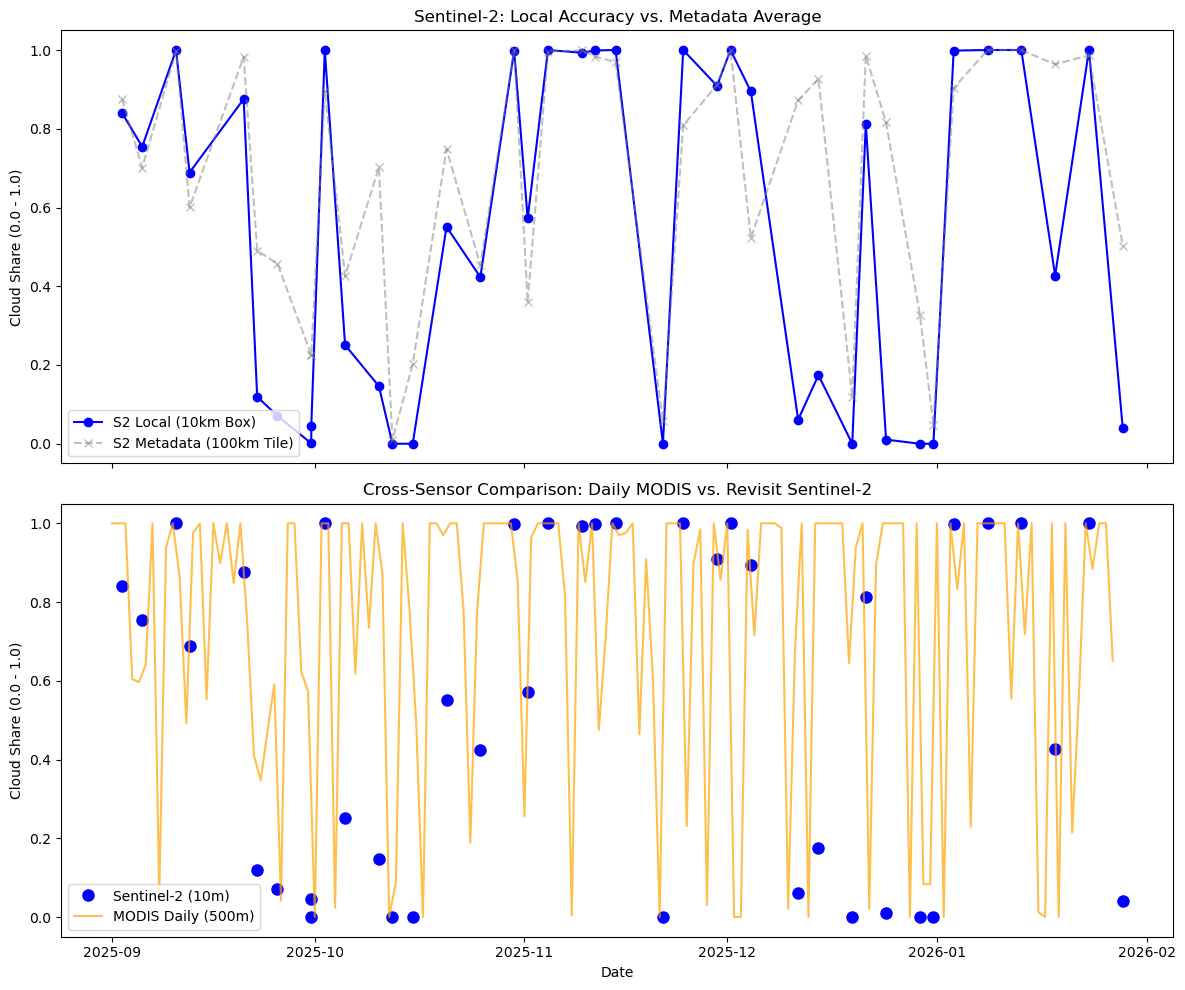

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: S2 Local vs S2 Metadata 
ax1.plot(df_s2['date'], df_s2['share'], 'o-', label='S2 Local (10km Box)', color='blue')
ax1.plot(df_s2['date'], df_s2['meta']/100, 'x--', label='S2 Metadata (100km Tile)', color='gray', alpha=0.5)
ax1.set_title("Sentinel-2: Local Accuracy vs. Metadata Average")
ax1.set_ylabel("Cloud Share (0.0 - 1.0)")
ax1.legend()

# Plot 2: S2 vs MODIS Daily 
ax2.plot(df_s2['date'], df_s2['share'], 'o', label='Sentinel-2 (10m)', color='blue', markersize=8)
ax2.plot(df_modis['date'], df_modis['share'], '-', label='MODIS Daily (500m)', color='orange', alpha=0.7)
ax2.set_title("Cross-Sensor Comparison: Daily MODIS vs. Revisit Sentinel-2")
ax2.set_ylabel("Cloud Share (0.0 - 1.0)")
ax2.set_xlabel("Date")
ax2.legend()

plt.tight_layout()
plt.show()

Let's dig into the comparison across the two sources.

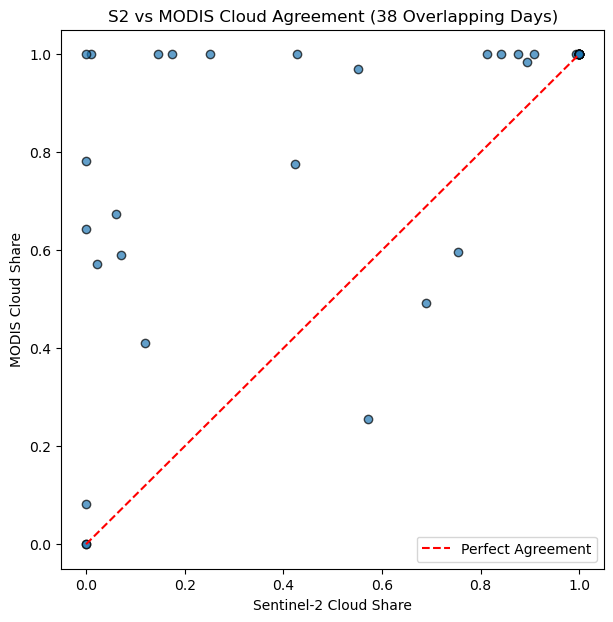

In [21]:
# 1. Ensure the 'date' column is just the Day (no hours/minutes)
df_combined['date'] = pd.to_datetime(df_combined['date']).dt.date

# 2. Pivot the table
# Group by date and source to remove duplicates
df_clean = df_combined.groupby(['date', 'source'])['share'].mean().reset_index()
# This moves 'S2' and 'MODIS' from rows into their own columns based on the date
df_pivot = df_clean.pivot(index='date', columns='source', values='share').dropna()

# 3. Plotting
plt.figure(figsize=(7, 7))
plt.scatter(df_pivot['S2'], df_pivot['MODIS'], alpha=0.7, edgecolors='k')

# 1:1 Reference Line
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')

plt.title(f"S2 vs MODIS Cloud Agreement ({len(df_pivot)} Overlapping Days)")
plt.xlabel("Sentinel-2 Cloud Share")
plt.ylabel("MODIS Cloud Share")
plt.legend()
plt.show()

Points to consider:
* How does a small cloud affect the cloud share in both sources?
* What would happen if we changed the MODIS threshold to ignore mixed cloud pixels?
* MODIS also measures "aerosol quantity". Should we be accounting for how this can also affect measures of reflectance, potentially as much as thick cloud?

## Masking clouds

Now that we realized there is a lot of cloud cover in this location, we should filter it out. We cannot learn much about the surface from all the cloudy days.

In the Section 4 GEE notebook we included a cloud cover filter for the Sentinel-2 data, `.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))`. This dropped entire images from the collection.

Since we have pixel-level data on cloud cover, we can do better and mask clouds from individual pixels, rather than dropping entire images. We'll first write functions to create pixel-level masks. Then we'll apply these to the collections and map the medians afterward.

In [27]:
# Sentinel-2 Pixel-Level Mask
def mask_s2_pixels(img):
    qa = img.select('QA60')
    # Bit 10 = Opaque clouds, Bit 11 = Cirrus
    mask = qa.bitwiseAnd(1 << 10).eq(0).And(qa.bitwiseAnd(1 << 11).eq(0))
    return img.updateMask(mask)

# MODIS Pixel-Level Mask
def mask_modis_pixels(img):
    qa = img.select('state_1km')
    # Bits 0-1 represent cloud state. 0 = clear.
    # We create a mask where those bits MUST equal 0.
    mask = qa.bitwiseAnd(3).eq(0)
    return img.updateMask(mask)

In [28]:
# Apply the masks to the collections
s2_masked_coll = s2_collection.map(mask_s2_pixels)
modis_masked_coll = modis_daily.map(mask_modis_pixels)

# Take the median of the masked pixels
s2_median_clean = s2_masked_coll.median()
modis_median_clean = modis_masked_coll.median()

# Sentinel-2 Clean Views
Map.addLayer(s2_median_clean.clip(study_area), 
             {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 
             'S2 True Color (Masked)')

# MODIS Clean Views (Note: MODIS bands are named differently)
Map.addLayer(modis_median_clean.clip(study_area), 
             {'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'], 'min': 0, 'max': 3000}, 
             'MODIS True Color (Masked)')

Map

Map(bottom=363089.0, center=[48.391600000000004, -4.0507], controls=(WidgetControl(options=['position', 'trans…

Now it looks like what we expected! 

How does the comparison of Sentinel-2 to MODIS look? 10m vs 500m is a big difference!

Note also that all layers we previously added to the map are still there. We can clear them all or **remove specific layers**.

In [29]:
# to clear all
# Map.clear_layers()

# clear named layers
Map.remove_layer('S2 Median')
Map.remove_layer('S2 True Color')

You can also remove layers in the interactive map by clicking the trash can icon next to the layer name.

## Visualizing different bands

We have so far visualized true colors - red, green, and blue - which show the surface as we would see it with our own eyes. But we can choose different colors using different bands! This let's us "see" things the human eye cannot.

We'll do two visualizations:
1. **False color infrared**. This makes vegetation "pop," since plants reflect near-infrared (NIR) like a mirror. "Healthy" vegetation will glow bright red. We will just swap red, B5, for NIR, B8
2. **Short-wave infrared**. This makes water "pop," since water strongly reflects short-wave infrared (SWIR). Here we will swap red for SWIR 1 and green for red.

In [30]:
# 1. Define Visualization Parameters
# False Color Infrared: Vegetation is Red, Water is Black
s2_vis_false = {'bands': ['B8', 'B4', 'B3'], 'min': 0, 'max': 3000}

# SWIR (Short-Wave Infrared): Water is Deep Blue/Black, Land is Brown/Green
# This makes the reservoir boundary incredibly sharp
s2_vis_water = {'bands': ['B11', 'B8', 'B4'], 'min': 0, 'max': 3000}

# 2. Add to Map
Map.addLayer(s2_median_clean.clip(study_area), s2_vis_false, 'S2 False Color (NIR)')
Map.addLayer(s2_median_clean.clip(study_area), s2_vis_water, 'S2 Water Highlight (SWIR)')

Map.centerObject(study_area, 12)

Note that since we didn't call `Map` here we have to scroll up to see the new layers. Can we clearly see all water from the street map?

# 3. Deriving indicators

We have just seen an example of some of the power of using different bands to identify different aspects of the Earth's surface. In particular, we saw how certain bands can help to identify healthy vegetation and water. This fact underlies common indicators like the NDVI (Normalized Difference Vegetation Index) and the NDWI (Normalized Difference Water Index).

The math behind NDVI and NDWI is the same, just using different "colors." 

**NDVI (Vegetation)** uses NIR and Red. It highlights the "Red Edge" where plants absorb visible red for photosynthesis but reflect NIR.

$$NDVI = \frac{NIR - Red}{NIR + Red}$$

**NDWI (Water)** uses green and NIR (or SWIR). Water absorbs NIR and SWIR almost completely, making it stand out against land and vegetation which reflect it. On the other hand, water strongly reflects green. 

$$NDWI = \frac{Green - NIR}{Green + NIR}$$

This formula maximizes the contrast between water and everything else. It will give positive values for water pixels and negative values for other land cover. The formula will vary by satellite depending on what bands are available (see this [link](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/)).

We'll focus today on calculating and mapping NDWI. First, let's do it for the cloud-masked median images we generated for Sentinel-2 and MODIS.

In [32]:
# 1. Calculate NDWI for Sentinel-2
# We use .normalizedDifference([Green, NIR])
s2_ndwi = s2_median_clean.normalizedDifference(['B3', 'B8'])

# 2. Calculate NDWI for MODIS
# For MODIS: Band 4 is Green, Band 2 is NIR
modis_ndwi = modis_median_clean.normalizedDifference(['sur_refl_b04', 'sur_refl_b02'])

# 3. Define a Water Palette
# Values from -1 (Dry) to 0 (Neutral) to 1 (Wet)
ndwi_viz = {
    'min': -0.5, 
    'max': 0.5, 
    'palette': ['green', 'white', 'blue']
}

# 4. Add to Map
Map.addLayer(s2_ndwi.clip(study_area), ndwi_viz, 'S2 NDWI Index')
Map.addLayer(modis_ndwi.clip(study_area), ndwi_viz, 'MODIS NDWI Index')

Map.centerObject(study_area, 13)

Map

Map(bottom=363089.0, center=[48.391601925802455, -4.050586571849982], controls=(WidgetControl(options=['positi…

Use the inspector to see actual NDWI value at different points.

What do we observe about the two maps? What water is detected?

.

.

.

.

.

.

.

.

.

Why can't MODIS see the lake? The Lac du Drennec is roughly 1.1 km$^2$. A single MODIS pixel is 500x500 km, but the lake is irregular in shape so most of these pixels will overlap with vegetation. This dilutes the NDWI calculation, meaning the lake disappears into background noise.

Why can't Sentinel-2 see the smaller ponds and streams we see on the OpenStreetMap layer? With a 10 m pixel, these could be expected to show up. Unfortunately, for a pixel to show a positive and large NDWI value, the majority of the pixel must be water. A stream running through vegetation, even if 5 m wide, will be offset by the very strong NIR reflection from vegetation - much stronger than the absorption from water. Another issue is tree canopy, which can mask water bodies while a map would not. 

If we wanted to really see these small water bodies, we would need **Planet** data (3m) or other high-resolution datasets. These are typically not free, unfortunately.

## Switching contexts: Alau dam

Let's switch a context where these satellites may be better able to detect varation in surface water. 

In September 2024, the Alau dam outside Maiduguri in Nigeria collapsed, and the resulting floods caused at least 37 deaths and displacing over two million people ([BBC article](https://www.bbc.com/news/articles/c1kwepevkzxo). This was a devastating event. Can the Sentinel-2 and MODIS satellites detect the water in the dam and the floods after the collapse?

The Alau dam is much larger than the Lac du Drennec. This area of Nigeria is also more arid, making the spectral signature of water more clear beucase there is less vegetation to reflect NIR.

We'll first write some code to create the new image collections. Then we will visualize the median image again, after masking clouds. We'll restrict the median to just May-August 2024, before the dam collapse, to get a "pre" flood picture. We will create a 20 x 20 km box this time to cover the whole dam and much of Maiduguri.

In [39]:
# 1. New Location and Study Area
alau_coords = [13.2335, 11.7396] # [lon, lat]
alau_point = ee.Geometry.Point(alau_coords)
alau_area = alau_point.buffer(10000).bounds() # 10km box

# 2. Date Range: May to August 2024, pre-collapse
start_date = '2024-05-01'
end_date = '2024-08-31'

# 3. Load and Mask data
s2_pre_coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterBounds(alau_area)
               .filterDate(start_date, end_date)
               .map(mask_s2_pixels))
modis_pre_coll = (ee.ImageCollection('MODIS/061/MOD09GA')
                  .filterBounds(alau_area)
                  .filterDate(start_date, end_date)
                  .map(mask_modis_pixels))

# 4. Generate Medians and NDWI
s2_pre_median = s2_pre_coll.median()
modis_pre_median = modis_pre_coll.median()
s2_pre_ndwi = s2_pre_median.normalizedDifference(['B3', 'B8'])
modis_pre_ndwi = modis_pre_median.normalizedDifference(['sur_refl_b04', 'sur_refl_b02'])

In [41]:
MapPre = geemap.Map()
MapPre.centerObject(alau_point, 12)

# Visualization Parameters
s2_rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
ndwi_viz = {
    'min': -0.5, 
    'max': 0.5, 
    'palette': ['green', 'white', 'blue']
}
# Add Layers
MapPre.addLayer(s2_pre_median.clip(alau_area), s2_rgb_vis, 'S2 True Color (Pre-Collapse)')
MapPre.addLayer(s2_pre_ndwi.clip(alau_area), ndwi_viz, 'S2 NDWI (Pre-Collapse)')
MapPre.addLayer(modis_pre_ndwi.clip(alau_area), ndwi_viz, 'MODIS NDWI (Pre-Collapse)')

MapPre

Map(center=[11.739600000000001, 13.2335], controls=(WidgetControl(options=['position', 'transparent_bg'], posi…

Do we detect more of the water? Use the inspector to check the values under MODIS and Sentinel-2.

Let's look at the distribution of NDWI values in the two data sources for this median pre-collapse image. Because there are millions of pixels in the Sentinel-2 image, we'll run the histogram on the GEE server.

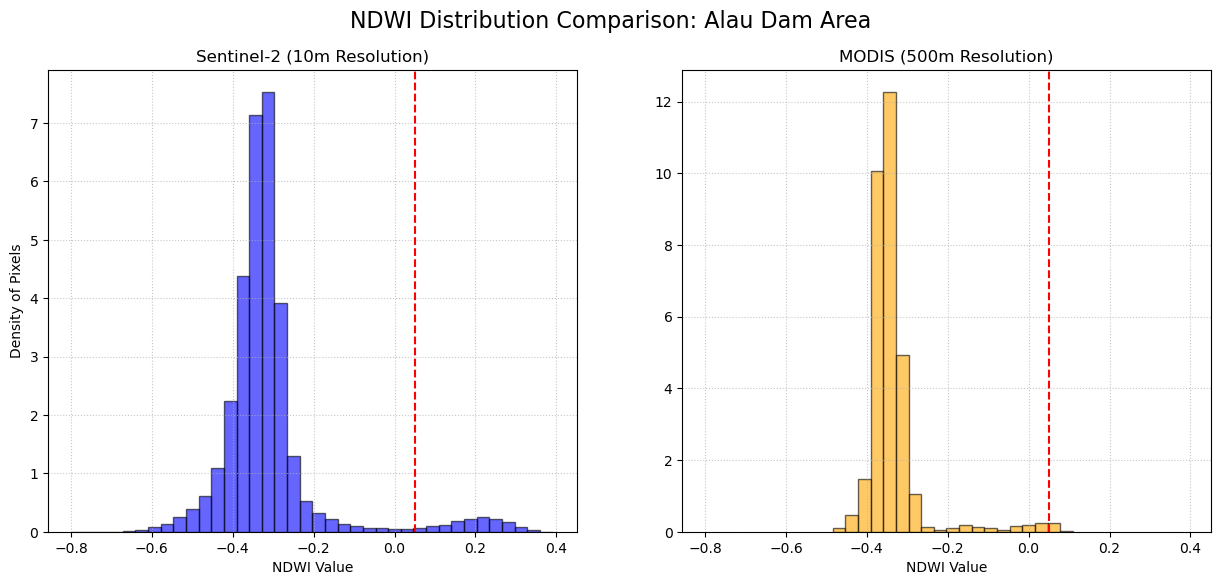

In [45]:
# 1. Get Histogram for Sentinel-2 (using 'nd' as discovered)
s2_hist = s2_pre_ndwi.reduceRegion(
    reducer=ee.Reducer.histogram(50),
    geometry=alau_area,
    scale=30,
    maxPixels=1e9
).getInfo()['nd']

# 2. Get Histogram for MODIS (also outputs as 'nd')
mod_hist = modis_pre_ndwi.reduceRegion(
    reducer=ee.Reducer.histogram(20), # Fewer bins for MODIS since it's coarser
    geometry=alau_area,
    scale=500,
    maxPixels=1e9
).getInfo()['nd']

# 3. Prepping histogram data from the two sources
def prep_hist(data):
    counts = np.array(data['histogram'])
    # Normalize counts to density so the area under the curve is 1
    density = counts / (counts.sum() * data['bucketWidth'])
    x_axis = [data['bucketMin'] + (i * data['bucketWidth']) for i in range(len(counts))]
    return x_axis, density, data['bucketWidth']

s2_x, s2_y, s2_w = prep_hist(s2_hist)
mod_x, mod_y, mod_w = prep_hist(mod_hist)

# 4. Plotting Side-by-Side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

# Plot Sentinel-2
ax1.bar(s2_x, s2_y, width=s2_w, color='blue', alpha=0.6, edgecolor='black')
ax1.set_title('Sentinel-2 (10m Resolution)')
ax1.set_ylabel('Density of Pixels')
ax1.axvline(0.05, color='red', linestyle='--')

# Plot MODIS
ax2.bar(mod_x, mod_y, width=mod_w, color='orange', alpha=0.6, edgecolor='black')
ax2.set_title('MODIS (500m Resolution)')
ax2.axvline(0.05, color='red', linestyle='--')

for ax in [ax1, ax2]:
    ax.set_xlabel('NDWI Value')
    ax.grid(True, linestyle=':', alpha=0.7)

plt.suptitle('NDWI Distribution Comparison: Alau Dam Area', fontsize=16)
plt.show()

There is a clear distinction of classifications for Sentinel-2. Not so much for MODIS. Based on this, we might consider setting different "water thresholds" for each source to define a binary water mask.

Now, let's show the NDWI after the dam collapse.

In [46]:
# 1. New Location and Study Area
alau_coords = [13.2335, 11.7396] # [lon, lat]
alau_point = ee.Geometry.Point(alau_coords)
alau_area = alau_point.buffer(10000).bounds() # 10km box

# 2. Date Range: May to August 2024, pre-collapse
start_date = '2024-09-01'
end_date = '2024-10-31'

# 3. Load and Mask data
s2_post_coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterBounds(alau_area)
               .filterDate(start_date, end_date)
               .map(mask_s2_pixels))
modis_post_coll = (ee.ImageCollection('MODIS/061/MOD09GA')
                  .filterBounds(alau_area)
                  .filterDate(start_date, end_date)
                  .map(mask_modis_pixels))

# 4. Generate Medians and NDWI
s2_post_median = s2_post_coll.median()
modis_post_median = modis_post_coll.median()
s2_post_ndwi = s2_post_median.normalizedDifference(['B3', 'B8'])
modis_post_ndwi = modis_post_median.normalizedDifference(['sur_refl_b04', 'sur_refl_b02'])

In [47]:
MapPost = geemap.Map()
MapPost.centerObject(alau_point, 12)

# Visualization Parameters
s2_rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
ndwi_viz = {
    'min': -0.5, 
    'max': 0.5, 
    'palette': ['green', 'white', 'blue']
}
# Add Layers
MapPost.addLayer(s2_post_median.clip(alau_area), s2_rgb_vis, 'S2 True Color (Post-Collapse)')
MapPost.addLayer(s2_post_ndwi.clip(alau_area), ndwi_viz, 'S2 NDWI (Post-Collapse)')
MapPost.addLayer(modis_post_ndwi.clip(alau_area), ndwi_viz, 'MODIS NDWI (Post-Collapse)')

MapPost

Map(center=[11.739600000000001, 13.2335], controls=(WidgetControl(options=['position', 'transparent_bg'], posi…

Do we observe differences?

Let's plot the histograms again.

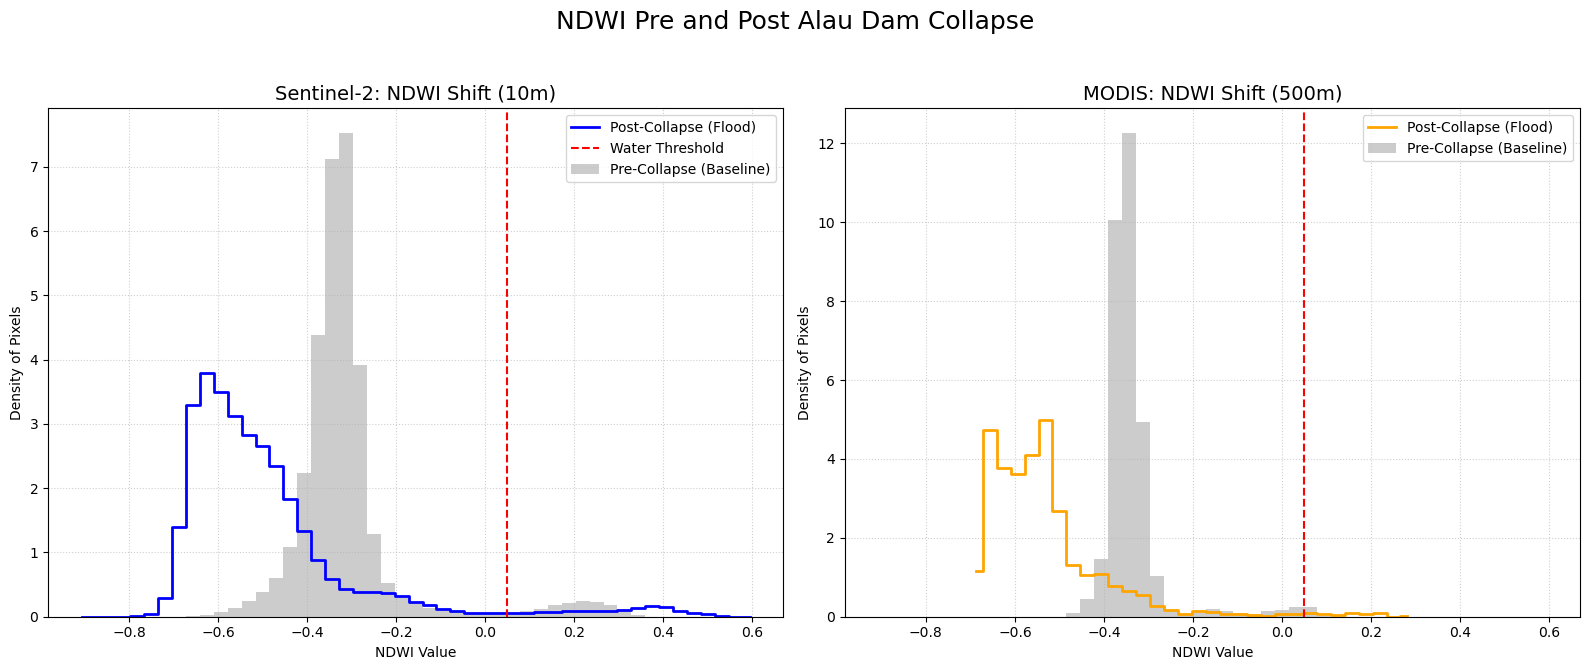

In [48]:
# 1. Histogram data from GEE function
def get_hist_data(image, geometry, scale, bins=50):
    hist = image.reduceRegion(
        reducer=ee.Reducer.histogram(bins),
        geometry=geometry,
        scale=scale,
        maxPixels=1e9
    ).getInfo()
    
    # Use 'nd' as the key since normalizedDifference defaults to it
    data = hist['nd']
    counts = np.array(data['histogram'])
    # Normalize to density so we can compare Pre and Post even if cloud masking
    # resulted in different total pixel counts
    density = counts / (counts.sum() * data['bucketWidth'])
    x_axis = [data['bucketMin'] + (i * data['bucketWidth']) for i in range(len(counts))]
    return x_axis, density, data['bucketWidth']

# 2. Fetch all four distributions
s2_pre_x, s2_pre_y, s2_pre_w = get_hist_data(s2_pre_ndwi, alau_area, 30)
s2_post_x, s2_post_y, s2_post_w = get_hist_data(s2_post_ndwi, alau_area, 30)
mod_pre_x, mod_pre_y, mod_pre_w = get_hist_data(modis_pre_ndwi, alau_area, 500, bins=20)
mod_post_x, mod_post_y, mod_post_w = get_hist_data(modis_post_ndwi, alau_area, 500, bins=20)

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True)

# Sentinel-2 Plot (Left)
ax1.bar(s2_pre_x, s2_pre_y, width=s2_pre_w, color='gray', alpha=0.4, label='Pre-Collapse (Baseline)')
ax1.step(s2_post_x, s2_post_y, color='blue', where='mid', label='Post-Collapse (Flood)', linewidth=2)
ax1.set_title('Sentinel-2: NDWI Shift (10m)', fontsize=14)
ax1.axvline(0.05, color='red', linestyle='--', label='Water Threshold')

# MODIS Plot (Right)
ax2.bar(mod_pre_x, mod_pre_y, width=mod_pre_w, color='gray', alpha=0.4, label='Pre-Collapse (Baseline)')
ax2.step(mod_post_x, mod_post_y, color='orange', where='mid', label='Post-Collapse (Flood)', linewidth=2)
ax2.set_title('MODIS: NDWI Shift (500m)', fontsize=14)
ax2.axvline(0.05, color='red', linestyle='--')

# Formatting
for ax in [ax1, ax2]:
    ax.set_xlabel('NDWI Value')
    ax.set_ylabel('Density of Pixels')
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)

plt.suptitle('NDWI Pre and Post Alau Dam Collapse', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Practice - Flood Detection

As an exercise/practice, think through the code for creating a time series of NDWI for each image in the collection. How would you identify the flooded areas? How would you account for potentially seasonality in water that isn't flooding?